# Week4 Kaggle Data Set from BBC

In [1]:
from PIL import Image
import glob
import os
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt      
from matplotlib.pyplot import figure
from sklearn.svm import SVC                                
from sklearn.model_selection import train_test_split
import pathlib
import os
import string
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings 
#import gensim
#from gensim.models import Word2Vec
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import math
from sklearn.metrics import accuracy_score, confusion_matrix
import time
from sklearn.cluster import KMeans

In [2]:
print(pathlib.Path().absolute())
print (os.getcwd())


C:\Users\Rivendell\Documents\Data_Science_masters\Boulder_Colorado\2023_Spring_Session_1\DTSA 5510 Unsupervised Algorithms in Machine Learning\Week_4
C:\Users\Rivendell\Documents\Data_Science_masters\Boulder_Colorado\2023_Spring_Session_1\DTSA 5510 Unsupervised Algorithms in Machine Learning\Week_4


In [3]:
class color:
    PURPLE = "\033[95m"
    CYAN = "\033[96m"
    DARKCYAN = "\033[36m"
    BLUE = "\033[94m"
    GREEN = "\033[92m"
    YELLOW = "\033[93m"
    RED = "\033[91m"
    BOLD = "\033[1m"
    UNDERLINE = "\033[4m"
    END = "\033[0m"

In [4]:
current_dir = (os.getcwd())
path = "\learn-ai-bbc"

print(color.UNDERLINE + color.BOLD + color.RED + "BBC Test Data" + color.END)    
File_name = None
File_name = "\BBC News Test.csv"
File_Path = current_dir + path + File_name
print(File_Path)
BBC_News_Test_Data = pd.read_csv(File_Path)
print(BBC_News_Test_Data.head())


print()
print()
print(color.UNDERLINE + color.BOLD + color.RED + "BBC Train Data" + color.END)
File_name = None
File_name = "\BBC News Train.csv"
File_Path = current_dir + path + File_name
BBC_News_Train_Data = pd.read_csv(File_Path)
print(BBC_News_Train_Data.head())

print()
print()
print(color.UNDERLINE + color.BOLD + color.RED + "BBC Sample Solution Data" + color.END)
File_name = None
File_name = "\BBC News Sample Solution.csv"
File_Path = current_dir + path + File_name
BBC_News_Sample_Solution = pd.read_csv(File_Path)
print(BBC_News_Sample_Solution.head())




BBC Test Data
C:\Users\Rivendell\Documents\Data_Science_masters\Boulder_Colorado\2023_Spring_Session_1\DTSA 5510 Unsupervised Algorithms in Machine Learning\Week_4\learn-ai-bbc\BBC News Test.csv
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough...


BBC Train Data
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168

## Plot number of word per category and number of Articles in each category
## this could affect predictions by quite a bit if more keywords are present in one
## Category versus another

In [5]:
plt.rcParams["figure.figsize"] = (10,5)

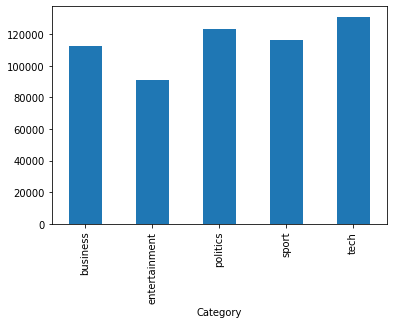

In [6]:
BBC_News_Train_Data['Word_Count'] = BBC_News_Train_Data["Text"].str.split().apply(len) # add a new column with word counts

Train_grouped = BBC_News_Train_Data.groupby(by='Category')['Word_Count'].sum()
Train_grouped.plot.bar(x='Category', y='Word_Count', width = 0.5)
plt.show()
#BBC_News_Test_Data['Word_Count'] = BBC_News_Test_Data["Text"].str.split().apply(len) # add a new column with word counts
#Test_grouped = BBC_News_Test_Data.groupby(by='Category')['Word_Count'].sum()

AxesSubplot(0.125,0.125;0.775x0.755)


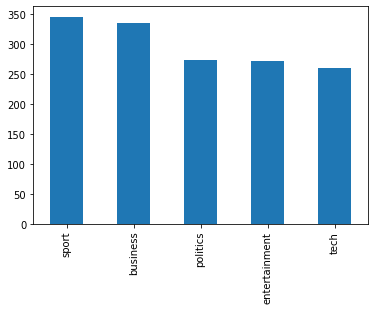

In [7]:
print(BBC_News_Train_Data['Category'].value_counts().plot.bar())

## Unigue Categories

In [8]:

print(BBC_News_Sample_Solution["Category"].unique())


['sport' 'tech' 'business' 'entertainment' 'politics']


## Consolidate all the text from train and test into one 
## dataframe for possible use later in the analysis

In [9]:
All_Articles = pd.concat([BBC_News_Train_Data["Text"], BBC_News_Test_Data["Text"]], axis=0)  

In [10]:
All_Articles.head()
print(len(BBC_News_Train_Data["Text"]))
print(len(BBC_News_Test_Data["Text"]))
print(len(All_Articles))
All_Articles.head()

1490
735
2225


0    worldcom ex-boss launches defence lawyers defe...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens in ...
3    lifestyle  governs mobile choice  faster  bett...
4    enron bosses in $168m payout eighteen former e...
Name: Text, dtype: object

## Function to remove unwanted text and stop words

In [11]:
def Text_Removal(Text_Dataframe, Text_Column_Name):
    
    # Function to reduce text to a usable set of words for identifying topics
    # and the article category
    
    Word_Data = Text_Dataframe.copy()
    #remove unecessary punction and text that do not qualify as words
    Word_Data[Text_Column_Name] = Word_Data[Text_Column_Name].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
    Word_Data[Text_Column_Name] = Word_Data[Text_Column_Name].apply(lambda row: re.sub(r'[0-9]+', '', row))
    
    #remove stopwords or words that are not unique  like... (the, and, or , that)
    stop_words = stopwords.words('english')
    Word_Data[Text_Column_Name] = Word_Data[Text_Column_Name].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    
    return Word_Data[Text_Column_Name]

## Function to determine accuracy

In [12]:
import itertools

def label_permute_compare(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
# your code here

    total_time = 0
    end_time = 0
    start_time = 0
    start_time = time.time()
    
    Model_Check = None
    Model_Check = yp
    label = None
    label = ytdf

    Current_Accuracy_Score = 0
    New_Accuracy_Score = 0
    Best_Permutation = ()
    Best_Percent_Matched = 0
    Model_Label_list_Final = []
    Total_Rows = len(label)
  
    label_list = pd.DataFrame()
    label_list = label_list.append({'Category':'sport', 'Value':0, 'Accuracy':0},ignore_index=True)
    label_list = label_list.append({'Category':'tech', 'Value':1, 'Accuracy':0},ignore_index=True)
    label_list = label_list.append({'Category':'business', 'Value':2, 'Accuracy':0},ignore_index=True)
    label_list = label_list.append({'Category':'entertainment', 'Value':3, 'Accuracy':0},ignore_index=True)
    label_list = label_list.append({'Category':'politics', 'Value':4, 'Accuracy':0},ignore_index=True)

    Label_array = label["Category"].to_numpy()

    Value_List = (0,1,2,3,4)
    Value_List_per = itertools.permutations(Value_List,5)
    for val in Value_List_per:

    
        for z in range(len(val)):
            #print(val[z])
            #print(label_list.loc[[z]])
            label_list.loc[z, ['Value']] = val[z]

        Model_Label_list1 = []
        for i in range(len(Model_Check)):
            Test = label_list.loc[label_list['Value'] == Model_Check[i]] 
            Class_Value = Test['Category'].to_string(index=False).lstrip()  
            Model_Label_list1.append(Class_Value)
    

        New_Accuracy_Score = accuracy_score(Label_array, Model_Label_list1, normalize=False)
        if New_Accuracy_Score > Current_Accuracy_Score:
            
            Current_Accuracy_Score = New_Accuracy_Score
            Best_Permutation = val
            Best_Percent_Matched = New_Accuracy_Score/Total_Rows
            Model_Label_list_Final = Model_Label_list1
            

    print('Best configuration: ',Best_Permutation,' - ',Current_Accuracy_Score,' - ',Best_Percent_Matched)
    
    print(Total_Rows)
    end_time = time.time()
    total_time = end_time - start_time
    print('Total Time: ',total_time)
    
    print()
    print(confusion_matrix(Label_array, Model_Label_list_Final))
    print()
    
    return (Best_Permutation,Best_Percent_Matched)

## Function to predict Values


In [13]:
def Prediction_Function(w_matrix):

    sorted_matrix = np.argsort(w_matrix)
    number_of_rows, N = sorted_matrix.shape

    #Get's the max value based on the indices for the sorted data
    #basically grabs value in the sort that has the highest value
    #and stores that in an array of those values
    predicted_values = [[sorted_matrix[i][N - 1]] for i in range(number_of_rows)]
    
    #create empty array to hold each value from the 
    Predicted_Categories = np.empty(number_of_rows, dtype = np.int64)
    
    #store each chosen predicted value in an array
    for i in range(number_of_rows):
        Predicted_Categories[i] = predicted_values[i][0]
    print(type(Predicted_Categories))
    
    return Predicted_Categories

## Run tests on Training data

### After reviewing different avenues to vectorizing the text, I settled on TF-IDF as it seemd the most practical due to it's wide use. This takes the words and determines a value based on the number of time it appears in a document and also takes into account how often it appears in other documents. 

###  I ran multiple tests on the NMF model after getting the TF-IDF from using solver CD with Frobenius, beta loss itakura-saito failed due to data issues (the input matrix X cannot contain zeros), and then Solver mu with beta loss kullback-leibler.

### Anything combination with beta loss Frobenius resulted in approx .91 for accuracy.

### Beta Loss kullback-leibler with mu gave the best results but the init value did matter

### Init Values and results
### random - 0.61
### nndsvd - 0.93
### nndsvda - 0.961
### nndsvdar - 0.961

### Beta Loss kullback-leibler with solver mu and init of nndsvda returned a good accuracy 
### with no change using  an init of nndsvdar. So this will be the same configuration for the test set

In [14]:
warnings.simplefilter('ignore')
Article_Text = Text_Removal(BBC_News_Train_Data,"Text")

# Create TF-IDF matrix
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english")
tfidf_matrix = vectorizer.fit_transform(Article_Text)

# Create NMF model with N topics
Component_value = 5
nmf_model = NMF(n_components=Component_value, 
                #init='random', 
                #init='nndsvd', 
                init='nndsvda', 
                #init='nndsvdar', 
                solver = 'mu',
                #beta_loss = 'itakura-saito',
                beta_loss = 'kullback-leibler',
                #beta_loss = 'frobenius',
                ##l1_ratio = 0.5,
                random_state = 42
               )

nmf_matrix = nmf_model.fit_transform(tfidf_matrix)
#print(nmf_matrix)

    
predict_matrix = nmf_model.transform(tfidf_matrix)

Category_Labels = Prediction_Function(nmf_matrix)
#Category_Labels = Prediction_Function(predict_matrix)
print(Category_Labels)

Train_Labels = BBC_News_Train_Data.loc[:, ['ArticleId','Category']]
label_order, accuracy = label_permute_compare(Train_Labels, Category_Labels )
print('accuracy=', accuracy)
warnings.resetwarnings()

<class 'numpy.ndarray'>
[4 4 4 ... 4 2 2]
Best configuration:  (0, 2, 4, 3, 1)  -  1432  -  0.9610738255033557
1490
Total Time:  33.260549545288086

[[312   2   8   0  14]
 [  1 264   4   0   4]
 [  5   2 263   3   1]
 [  1   1   1 343   0]
 [  0   6   2   3 250]]

accuracy= 0.9610738255033557


## Now run tests using Test dataset, print and show text for first ten categories for Comparison and visual inspection


### Create Label List for use with export of data for Kaggle submission

In [15]:
warnings.simplefilter('ignore')
label_list = pd.DataFrame()
label_list = label_list.append({'Category':'sport', 'Value':0, 'Accuracy':0},ignore_index=True)
label_list = label_list.append({'Category':'tech', 'Value':1, 'Accuracy':0},ignore_index=True)
label_list = label_list.append({'Category':'business', 'Value':2, 'Accuracy':0},ignore_index=True)
label_list = label_list.append({'Category':'entertainment', 'Value':3, 'Accuracy':0},ignore_index=True)
label_list = label_list.append({'Category':'politics', 'Value':4, 'Accuracy':0},ignore_index=True)
print(label_list)
warnings.resetwarnings()


        Category  Value  Accuracy
0          sport      0         0
1           tech      1         0
2       business      2         0
3  entertainment      3         0
4       politics      4         0


In [20]:
warnings.simplefilter('ignore')

print("Look at some results for visual inspection before exporting data for submission file")

Article_Text = Text_Removal(BBC_News_Test_Data,"Text")
#print(BBC_News_Test_Data.head())
print()
#print(Article_Text.head(10))

# Create TF-IDF matrix
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english")
tfidf_matrix = vectorizer.fit_transform(Article_Text)

# Create NMF model with N topics
Component_value = 5
nmf_model = NMF(n_components=Component_value, 
                init='nndsvda', 
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                ##l1_ratio = 0.5,
                random_state = 101
               )

nmf_matrix = nmf_model.fit_transform(tfidf_matrix)
Category_Labels = Prediction_Function(nmf_matrix)
   
#predict_matrix = nmf_model.transform(tfidf_matrix)
#Category_Labels = Prediction_Function(predict_matrix)

Submission_Data = BBC_News_Test_Data.copy()
Submission_Data['Category_Values'] = Category_Labels.tolist()
Submission_Data["Category_Description"] = ""

# create dataframe for Kaggle submission file
for index, row in label_list.iterrows():
    mask = (Submission_Data['Category_Values'] == row['Value'])
    Submission_Data.loc[mask, 'Category_Description'] = row['Category']
print()
print("Category Results")
print(Submission_Data.head(10))
    
warnings.resetwarnings()

Look at some results for visual inspection before exporting data for submission file

<class 'numpy.ndarray'>

Category Results
   ArticleId                                               Text  \
0       1018  qpr keeper day heads for preston queens park r...   
1       1319  software watching while you work software that...   
2       1138  d arcy injury adds to ireland woe gordon d arc...   
3        459  india s reliance family feud heats up the ongo...   
4       1020  boro suffer morrison injury blow middlesbrough...   
5         51  lewsey puzzle over disallowed try england s jo...   
6       2025  blair blasts tory spending plans tony blair ha...   
7       1479  former ni minister scott dies former northern ...   
8         27  career honour for actor dicaprio actor leonard...   
9        397  tsunami  to hit sri lanka banks  sri lanka s b...   

   Category_Values Category_Description  
0                0                sport  
1                3        entertainment  
2       

## Code to create file for Kaggle submission

In [21]:
Kaggle_Submission = Submission_Data[['ArticleId', 'Category_Description']].copy()
Kaggle_Submission.rename(columns={'Category_Description':'Category'}, inplace=True)
Kaggle_Submission.head()
current_dir = (os.getcwd())
path = "\learn-ai-bbc"

File_name = None
File_name = "\kaggle_Submission.csv"
File_Path = current_dir + path + File_name
Kaggle_Submission.to_csv (File_Path, index = False, header=True)

<>:5: DeprecationWarning: invalid escape sequence '\l'
<>:8: DeprecationWarning: invalid escape sequence '\k'
<>:5: DeprecationWarning: invalid escape sequence '\l'
<>:8: DeprecationWarning: invalid escape sequence '\k'
C:\Users\Rivendell\AppData\Local\Temp\ipykernel_6700\3069013050.py:5: DeprecationWarning: invalid escape sequence '\l'
  path = "\learn-ai-bbc"
C:\Users\Rivendell\AppData\Local\Temp\ipykernel_6700\3069013050.py:8: DeprecationWarning: invalid escape sequence '\k'
  File_name = "\kaggle_Submission.csv"


## Now to try a Supervised learning version

In [26]:
warnings.simplefilter('ignore')

Article_Text = Text_Removal(BBC_News_Train_Data,"Text")
Article_Text_Frame = pd.DataFrame(columns=['text'])
Article_Text_Frame['text'] = Article_Text.tolist()

#split data into X and y
y_train = BBC_News_Train_Data['Category'].values
X_train = Article_Text_Frame['text'].values

#create new vectorizer for supervised learning model
supervised_tfidfvector = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
Supervised_train_fit = supervised_tfidfvector.fit_transform(X_train) 

#create KMeans Model and train
kmeans = KMeans(n_clusters = 5, 
                init = 'k-means++', 
                algorithm = 'full', 
                random_state = 99)
supervised_yhat_train = kmeans.fit_predict(Supervised_train_fit)

#get accuracy
y_train_df = pd.DataFrame(y_train, columns=['Category'])
label_order, accuracy = label_permute_compare(y_train_df, supervised_yhat_train)
print('accuracy=', accuracy)
print(label_order, '\n')
warnings.resetwarnings()

Best configuration:  (3, 2, 1, 4, 0)  -  1340  -  0.8993288590604027
1490
Total Time:  69.58099102973938

[[328   0   1   1   6]
 [ 30 226   1   6  10]
 [ 64   0 204   2   4]
 [  1   0   0 345   0]
 [ 15   4   0   5 237]]

accuracy= 0.8993288590604027
(3, 2, 1, 4, 0) 



## Both the Training and Supervised Learning sets went well, but my Kaggle submission did not, I only received a 45% accuracy. 

## I visually inspected the output and it was hard to see where it wrong, but it almost seemed as if some predictions were off by one array wise, this could have been pure coinicidence though. 

## More than likely my predict or my accuracy test has issues

## Overall the supervised learning works well and seems a bit more consistent. The unsupervised version requires tweaking and experimentation

## With regards to the training data, I feel that we could use a larger set in general. The split on this set is 2/3 for the Train and a 1/3 for the test set for a 66/33 split. Typically in previous models splits are set at 80/20.

## The tech one seems to have faired worse than the others and it has the fewest articles and the most words in the train set. The sport and business seemed to do well on the test set, but they have the most articles and a decent number of words in the train set, which seems to show volume preference when it comes to number of articles and words when calculating things.

## One other Note: The random state did affect the supervised model , but did not affect the unsupervised model, so that might be an advantage for that process.